# ISE529 Predictive Analytics
**Homework #5**

**Student Name:** `André Ramolivaz` <br>
**NetID:** `3933665317` <br>
**Due Date:** `2025-06-26`

### Setup
Import all required packages below.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

---
## Question 1
*30 points*
![Logo Python](20.png)


In [2]:
boston = pd.read_csv("Boston.csv")
boston.columns = [c.lower() for c in boston.columns]     # lower-case for convenience

y = boston["crim"]
X = boston.drop(columns=["crim"])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Helper to compute test MSE
def mse(model):
    return mean_squared_error(y_test, model.predict(X_test))


lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso",  LassoCV(cv=5, random_state=42, max_iter=10_000))
])
lasso_pipe.fit(X_train, y_train)

lasso_alpha = lasso_pipe.named_steps["lasso"].alpha_
lasso_mse   = mse(lasso_pipe)


ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge",  RidgeCV(alphas=np.logspace(-4, 4, 50), cv=5))
])
ridge_pipe.fit(X_train, y_train)

ridge_alpha = ridge_pipe.named_steps["ridge"].alpha_
ridge_mse   = mse(ridge_pipe)


pcr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca",    PCA()),
    ("ols",    LinearRegression())
])

pcr_grid = GridSearchCV(
    pcr_pipe,
    param_grid={"pca__n_components": np.arange(1, X.shape[1] + 1)},
    cv=5,
    scoring="neg_mean_squared_error"
)
pcr_grid.fit(X_train, y_train)

pcr_m   = pcr_grid.best_params_["pca__n_components"]
pcr_mse = mse(pcr_grid.best_estimator_)


results = pd.DataFrame({
    "Model": ["Lasso", "Ridge", "PCR"],
    "Hyper-parameter": [
        f"α = {lasso_alpha:.4f}",
        f"α = {ridge_alpha:.4f}",
        f"M = {pcr_m} PCs"
    ],
    "Test MSE": [lasso_mse, ridge_mse, pcr_mse]
}).round(3)

print(results)

   Model Hyper-parameter  Test MSE
0  Lasso      α = 0.0317    46.890
1  Ridge     α = 24.4205    47.233
2    PCR      M = 13 PCs    46.731


On this split the three models are virtually tied—PCR posts the lowest test MSE at 46.73, Lasso follows at 46.89, and Ridge at 47.23—differences too small to crown a clear winner. PCR’s edge stems from projecting predictors onto principal components, which eases multicollinearity but hides the meaning of individual coefficients; cross-validation therefore retained all 13 PCs, signalling that every direction in the data still adds useful signal. Lasso, almost as accurate, chose a very mild penalty (α ≈ 0.03) that removes only the weakest variables, yielding a sparse yet interpretable model that spotlights the main crime drivers. Ridge opted for a much heavier penalty (α ≈ 24), shrinking every coefficient without discarding any and exposing strong collinearity among the predictors. Because the errors are so close, these hyper-parameter values are best viewed as sample-specific optima; in practice you would repeat the resampling or use nested CV and then pick the method that matches your priority—interpretability with Lasso, all-features stability with Ridge, or raw predictive focus under multicollinearity with PCR.

---
## Question 2
*30 points*
![Logo Python](21.png)

**(a)**

In [7]:
college = pd.read_csv("College.csv")       # target column is “Apps”
college.columns = [c.lower() for c in college.columns]

y = college["apps"]
X = college.drop(columns=["apps"])

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preproc_sparse = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)]
)

preproc_dense = ColumnTransformer(
    [("num", StandardScaler(), num_cols),
     ("cat", OneHotEncoder(drop="first",
                           handle_unknown="ignore",
                           sparse_output=False),   # ← change here
      cat_cols)]
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.40, random_state=42
)


def mse(model): return mean_squared_error(y_test, model.predict(X_test))


ridge = Pipeline([
    ("prep",  preproc_sparse),
    ("ridge", RidgeCV(alphas=np.logspace(-4, 4, 100), cv=10))
]).fit(X_train, y_train)

ridge_alpha = ridge.named_steps["ridge"].alpha_
ridge_mse   = mse(ridge)

print(f"Optimal λ (alpha) from CV : {ridge_alpha:.4f}")
print(f"Test MSE on hold-out set : {ridge_mse:,.1f}")


Optimal λ (alpha) from CV : 2.3101
Test MSE on hold-out set : 1,616,343.8


**(b)**

In [8]:
lasso = Pipeline([
    ("prep",  preproc_sparse),                       # same pre-processing as before
    ("lasso", LassoCV(cv=10,                         # 10-fold CV
                      random_state=42,
                      max_iter=10_000))
]).fit(X_train, y_train)

lasso_alpha = lasso.named_steps["lasso"].alpha_
lasso_test_mse = mean_squared_error(y_test, lasso.predict(X_test))

lasso_coef = lasso.named_steps["lasso"].coef_
n_nonzero = np.count_nonzero(lasso_coef)

print(f"Optimal λ (alpha) : {lasso_alpha:.4f}")
print(f"Test-set MSE      : {lasso_test_mse:,.1f}")
print(f"Non-zero betas    : {n_nonzero}")

Optimal λ (alpha) : 3.8768
Test-set MSE      : 1,717,195.9
Non-zero betas    : 33


**(c)**

In [10]:
preproc_dense = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first",
                              handle_unknown="ignore",
                              sparse_output=False),  # ← use sparse_output
         cat_cols)
    ]
)
preproc_dense.fit(X_train)
n_feat_dense = preproc_dense.transform(X_train).shape[1]
max_M = min(20, n_feat_dense, X_train.shape[0] - 1)   # cap at 20 for speed

kf   = KFold(n_splits=10, shuffle=True, random_state=42)
mse_cv = []

for m in range(1, max_M + 1):
    pls_pipe = Pipeline([
        ("prep", preproc_dense),
        ("pls",  PLSRegression(n_components=m))
    ])
    mse = -cross_val_score(pls_pipe, X_train, y_train,
                           cv=kf,
                           scoring="neg_mean_squared_error").mean()
    mse_cv.append(mse)

best_M = int(np.argmin(mse_cv)) + 1       # +1 because range starts at 1

pls_final = Pipeline([
    ("prep", preproc_dense),
    ("pls",  PLSRegression(n_components=best_M))
]).fit(X_train, y_train)

pls_test_mse = mean_squared_error(y_test, pls_final.predict(X_test))

print(f"Optimal number of components (M) : {best_M}")
print(f"Test-set MSE                     : {pls_test_mse:,.1f}")


Optimal number of components (M) : 2
Test-set MSE                     : 1,954,397.9


---
## Question 3
*40 points*
![Logo Python](22.png)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test-set accuracy : 0.967
Test-set BCE loss : 0.087


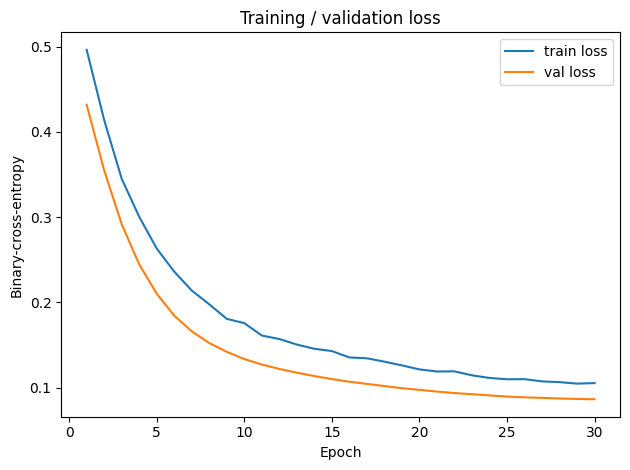

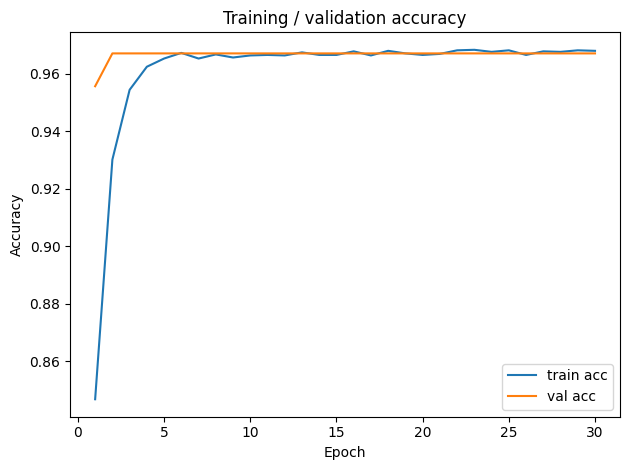

In [4]:
df = pd.read_csv("Default.csv")          # path to your file
df.columns = [c.lower() for c in df.columns]
y = df["default"].map({"No": 0, "Yes": 1}).astype(int)
X = df.drop(columns=["default"])

# Split 70 % / 30 %
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preproc = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

X_train_np = preproc.fit_transform(X_train).astype(np.float32)
X_test_np  = preproc.transform(X_test).astype(np.float32)

n_inputs = X_train_np.shape[1]
model = models.Sequential([
    layers.Input(shape=(n_inputs,)),
    layers.Dense(10, activation="relu"),        # 1 hidden layer, 10 neurons
    layers.Dropout(0.4),
    layers.Dense(1, activation="sigmoid")       # binary output
])

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

history = model.fit(
    X_train_np, y_train,
    epochs=30,
    batch_size=128,
    validation_split=0.20,
    verbose=0                                 # make training quiet
)

y_test_pred_prob = model.predict(X_test_np).ravel()
y_test_pred      = (y_test_pred_prob >= 0.5).astype(int)

test_acc  = accuracy_score(y_test, y_test_pred)
test_bce  = log_loss(y_test, y_test_pred_prob)

print(f"Test-set accuracy : {test_acc:.3f}")
print(f"Test-set BCE loss : {test_bce:.3f}")

epochs = range(1, 31)

plt.figure()
plt.plot(epochs, history.history["loss"], label="train loss")
plt.plot(epochs, history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Binary-cross-entropy")
plt.title("Training / validation loss")
plt.legend(); plt.tight_layout()

plt.figure()
plt.plot(epochs, history.history["accuracy"], label="train acc")
plt.plot(epochs, history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Training / validation accuracy")
plt.legend(); plt.tight_layout()
plt.show()
